# Competing Phases

To calculate the limiting chemical potentials of elements in the material (needed for calculating the defect formation energies) we need to consider the energies of all competing phases. `doped` does this by calling the `CompetingPhases` Class, which then queries Materials Project to obtain all the relevant competing phases to be calculated.
In some cases the Materials Project may not have all known phases in a certain chemical space, so it's a good idea to cross-check the generated competing phases with the [ICSD](https://icsd.products.fiz-karlsruhe.de/) in case you suspect any are missing.

For this functionality to work correctly, you must have POTCARs set up to work with `pymatgen` and you will also need an [API key](https://legacy.materialsproject.org/open) for the Materials Project (both of which are described on the [Installation docs page](https://doped.readthedocs.io/en/latest/Installation.html)).

- Note that at present this uses the 'Legacy API' from the Materials Project, and so the API key you use (either in `~/.pmgrc.yaml` or supplied to `CompetingPhases` with the `api_key` parameter) should correspond to the Materials Project legacy API. This key can be found [here](https://legacy.materialsproject.org/dashboard).

In [1]:
from doped.chemical_potentials import CompetingPhases

For example, if we want to calculate the chemical potentials with ZrO<sub>2</sub> as our host material, we would generate the relevant competing phases like so:

In [2]:
cp = CompetingPhases("ZrO2")  # default e_above_hull = 0.1 eV/atom
# if you don't have your MP API key set up in ~/.pmgrc.yaml, you can supply it as a parameter in this function

```{note}
**Note:** The current algorithm for how `doped` queries the Materials Project (MP) and determines relevant competing phases to be calculated, is that it first queries the MP for all phases with energies above hull less than `e_above_hull` (optional parameter in `CompetingPhases()`) in eV/atom in the chemical space of the host material. It then determines which of these phases border the host material in the phase diagram (i.e. which are competing phases and thus determine the chemical potentials), as well as which phases _would_ border the host material if their energies were downshifted by `e_above_hull`. The latter are included as well, and so `e_above_hull` acts as an uncertainty range for the MP-calculated formation energies, which may not be accurate due to functional choice (GGA vs hybrid DFT / GGA+U / RPA etc.), lack of vdW corrections etc.
```

`cp.entries` contains `pymatgen` `ComputedStructureEntry` objects for all the relevant competing phases, which includes useful data such as their structures, magnetic moment and (MP-calculated GGA) band gaps.

In [3]:
print(len(cp.entries))
print([entry.name for entry in cp.entries])

28
['O2', 'Zr', 'Zr3O', 'Zr4O', 'ZrO2', 'Zr3O', 'Zr3O', 'Zr2O', 'ZrO2', 'ZrO2', 'Zr', 'ZrO2', 'ZrO2', 'ZrO2', 'ZrO2', 'ZrO2', 'ZrO2', 'Zr', 'ZrO2', 'ZrO2', 'ZrO2', 'ZrO2', 'ZrO2', 'Zr', 'Zr6O11', 'ZrO2', 'ZrO2', 'ZrO2']


We can plot our phase diagram like this, which can show why certain phases are included as competing phases:

<Axes: xlabel='Fraction', ylabel='Formation energy (eV/atom)'>

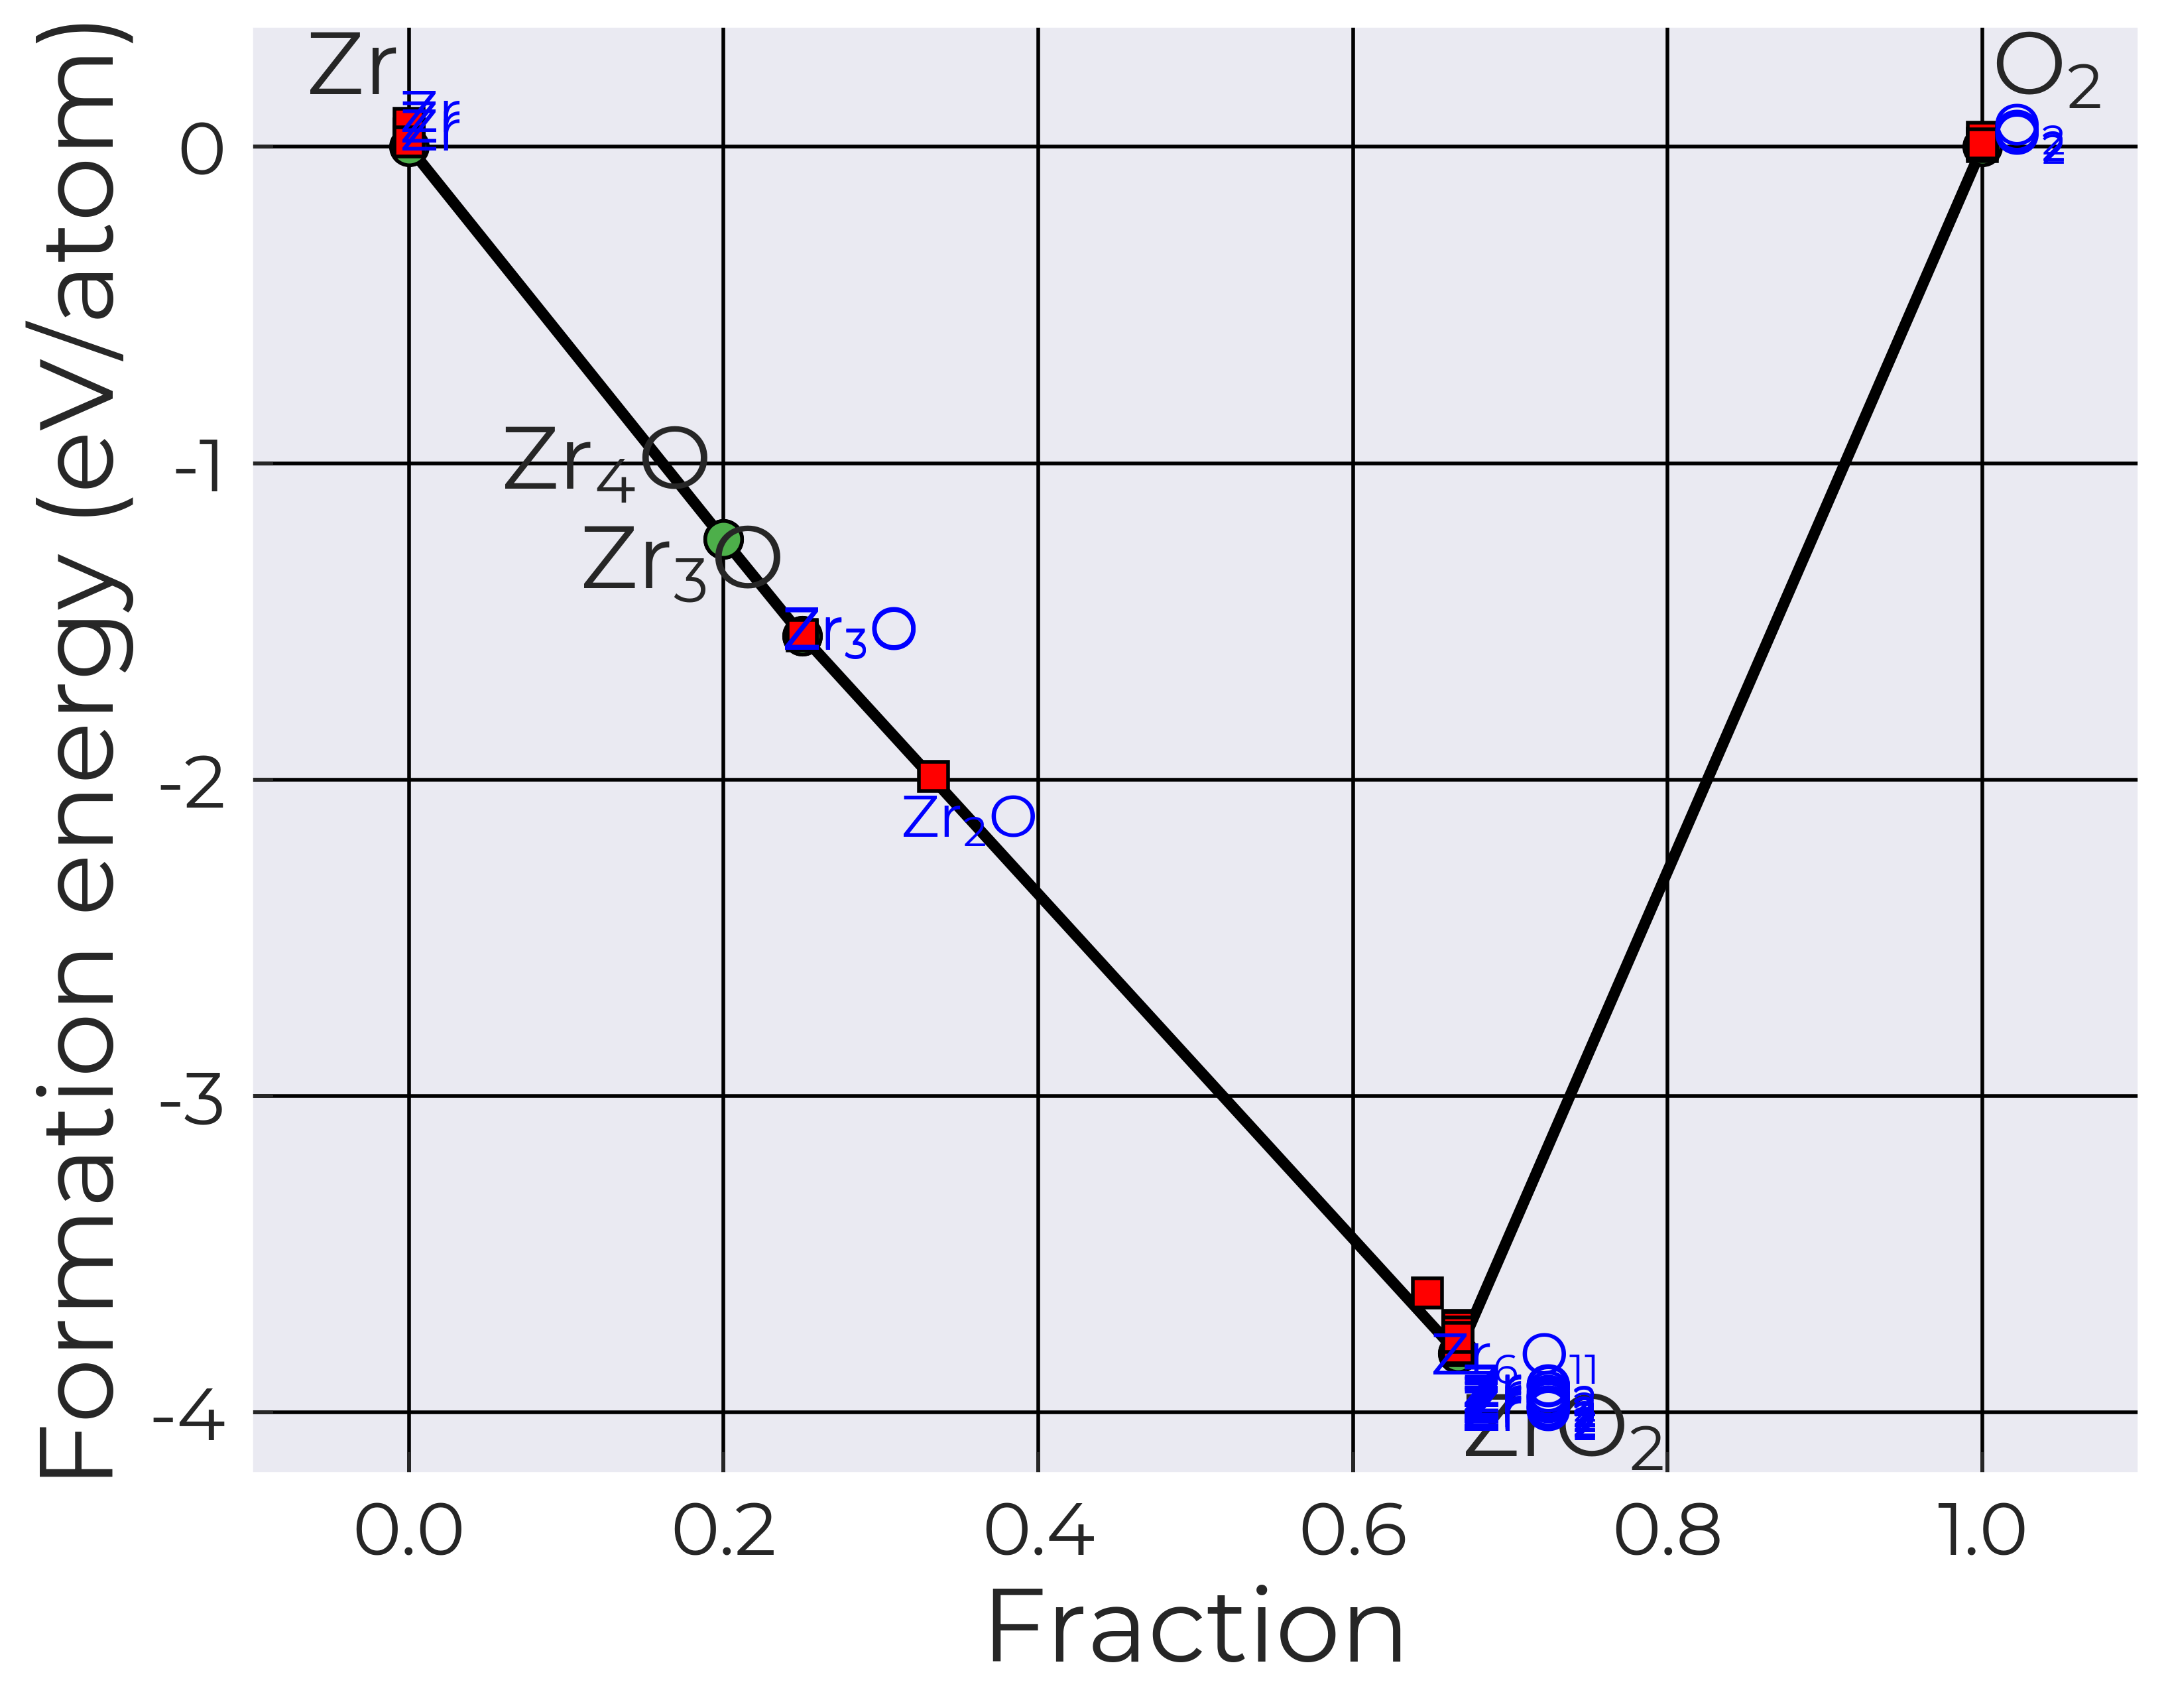

In [4]:
import doped
import matplotlib.pyplot as plt
plt.style.use(f"{doped.__path__[0]}/utils/doped.mplstyle")  # use doped style
from pymatgen.ext.matproj import MPRester
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDPlotter

system = ["Zr", "O"]  # system we want to get phase diagram for
mpr = MPRester()  # object for connecting to MP Rest interface, may need to specify API key here
entries = mpr.get_entries_in_chemsys(system)  # get all entries in the chemical system
pd = PhaseDiagram(entries)  # create phase diagram object
plotter = PDPlotter(pd, show_unstable=0.1, backend="matplotlib")  # plot phase diagram
plotter.get_plot()

In this case, we see that there are many low-energy polymorphs of ZrO<sub>2</sub> on the MP database. If for example we had already calculated the different polymorphs of ZrO<sub>2</sub> and knew the MP-predicted groundstate (i.e. with MP-calculated energy above hull of zero) was indeed the groundstate with our chosen DFT setup, we could then remove the extra ZrO<sub>2</sub> phases here like so:

In [5]:
cp.entries = [entry for entry in cp.entries if entry.name != "ZrO2" or entry.data["e_above_hull"] == 0]
print(len(cp.entries))
print([entry.name for entry in cp.entries])

12
['O2', 'Zr', 'Zr3O', 'Zr4O', 'ZrO2', 'Zr3O', 'Zr3O', 'Zr2O', 'Zr', 'Zr', 'Zr', 'Zr6O11']


Similarly, if we had prior knowledge that the Materials Project data was accurate for our chosen host material, or were doing a high-throughput investigation where we were happy to sacrifice some accuracy/completeness for efficiency, we could set `e_above_hull` to zero (i.e. total confidence in the MP data):

In [6]:
cp = CompetingPhases("ZrO2", e_above_hull=0)
print(len(cp.entries))
print([entry.name for entry in cp.entries])

4
['O2', 'Zr', 'Zr3O', 'ZrO2']


Indeed, if we plot our phase diagram again, only showing the stable MP entries, we see that only Zr<sub>3</sub>O and O<sub>2</sub> border ZrO<sub>2</sub>, and so these (plus any remaining elements; i.e. Zr here) are the only competing phases generated with `e_above_hull = 0`:

<Axes: xlabel='Fraction', ylabel='Formation energy (eV/atom)'>

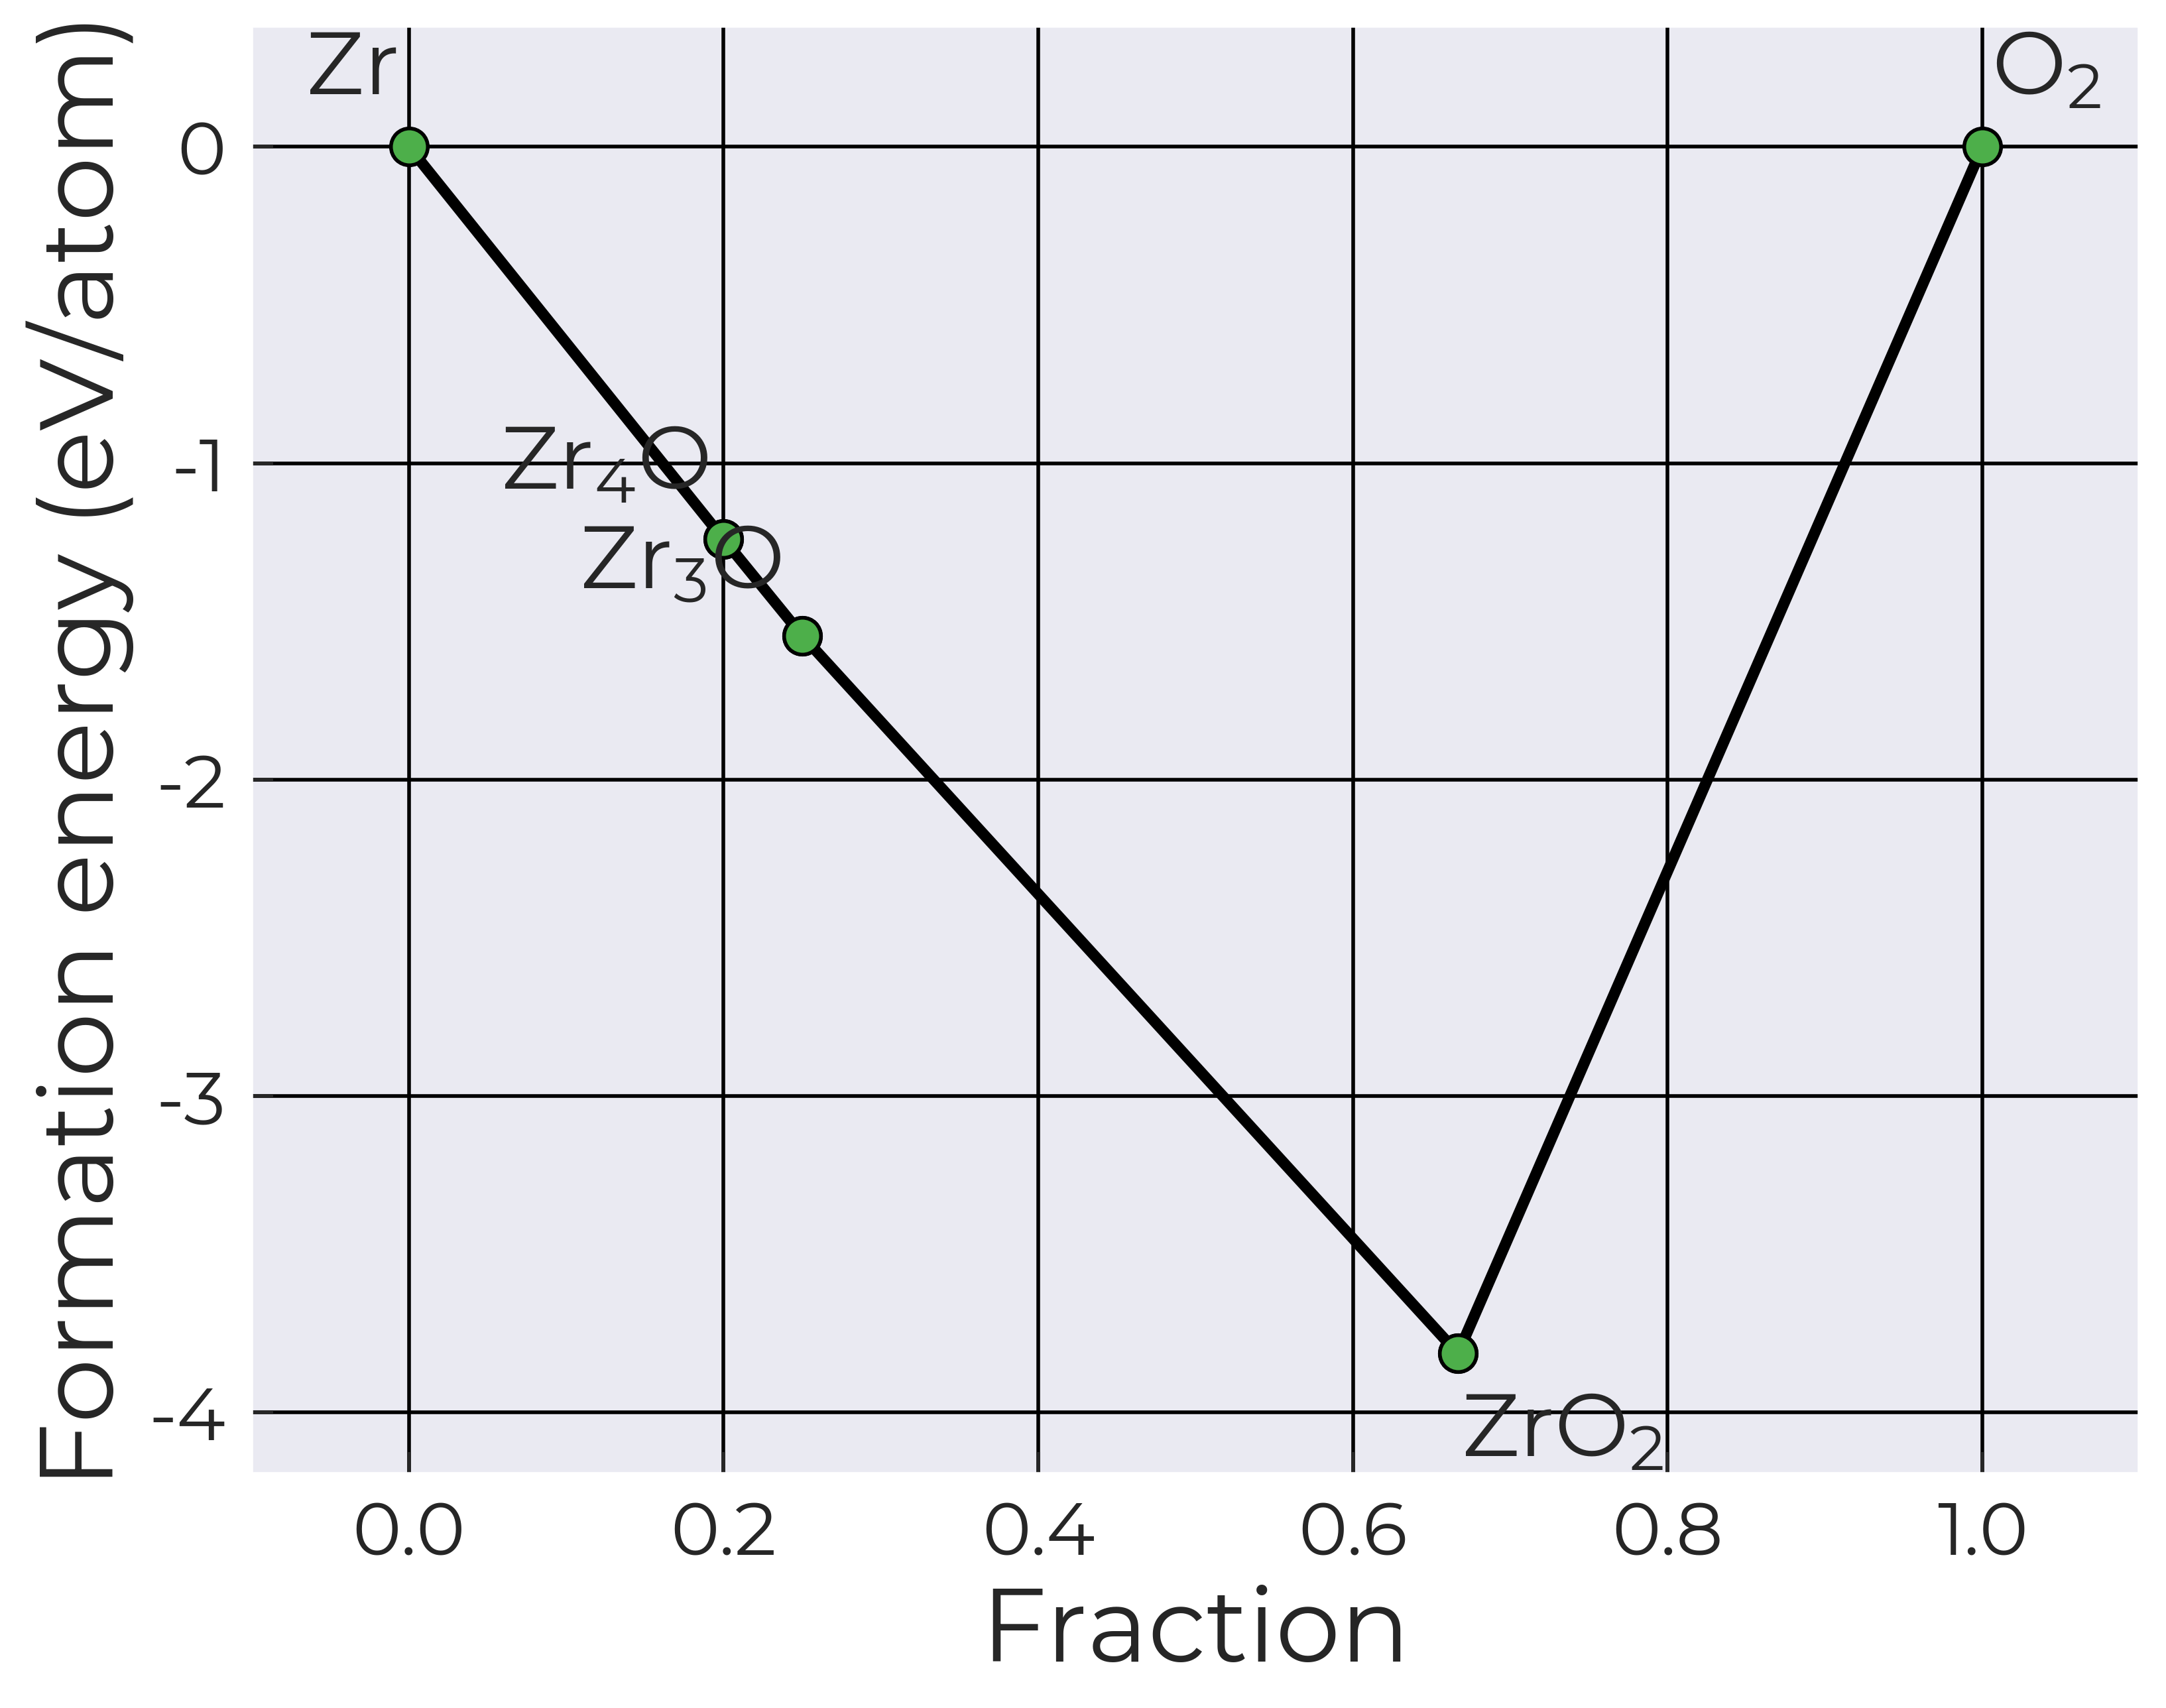

In [7]:
plotter = PDPlotter(pd, show_unstable=0, backend="matplotlib")  # plot phase diagram
plotter.get_plot()

## Generating input files
We can then set up the competing phase calculations with `doped` as described below, or use the `pymatgen` `ComputedStructureEntry` objects in `cp.entries` to set these up in your desired format with `python` / [`atomate`](https://atomate.org/) / [`AiiDA`](https://www.aiida.net/) etc.

k-points convergence testing is done at GGA (PBEsol by default) and is set up to account for magnetic moment convergence as well. Here we interface with [vaspup2.0](https://github.com/kavanase/vaspup2.0) to make it easy to use on the HPCs (with the `generate-converge` command to run the calculations and `data-converge` to quickly parse and analyse the results).

You may want to change the default `ENCUT` (350 eV) or k-point densities that the convergence tests span (5 - 60 kpoints/Å<sup>3</sup> for semiconductors & insulators and 40 - 120 kpoints/Å<sup>3</sup> for metals in steps of 5 kpoints/Å<sup>3</sup>). Note that `ISMEAR = -5` is used for metals by default (better kpoint convergence for energies but should not be used during metal geometry relaxations) and k-point convergence testing is not required for molecules (Γ-point sampling is sufficient).

Note that `doped` generates "molecule in a box" structures for the gaseous elemental phases
H<sub>2</sub>, O<sub>2</sub>, N<sub>2</sub>, F<sub>2</sub> and Cl<sub>2</sub>. The molecule is placed in
 a slightly-symmetry-broken (to avoid metastable electronic solutions) 30 Å cuboid box, and relaxed with Γ-point-only k-point sampling.

The kpoints convergence calculations are set up with:

In [9]:
cp.convergence_setup(user_incar_settings={'GGA': "PE"})  # For custom INCAR settings, any flags that aren't numbers or True/False need to be input as strings with quotation marks

O2 is a molecule in a box, does not need convergence testing


In [10]:
!ls competing_phases/Zr3O_EaH_0
!ls competing_phases/Zr3O_EaH_0/kpoint_converge

kpoint_converge
k3,3,3 k4,4,4


This creates a folder called `competing_phases` with all the relevant competing phases and k-point convergence test calculation directories. The naming format is `<Formula>_EaH_<MP Energy above Hull>` ('EaH' stands for 'Energy above Hull'). These can be quickly run on HPCs using [vaspup2.0](https://github.com/kavanase/vaspup2.0), by creating a `job` file for the HPC scheduler (`vaspup2.0` example [here](https://github.com/kavanase/vaspup2.0/blob/master/input/job)), copying it into each directory and running the calculation with a `bash` loop like:

```bash
for i in *EaH*  # (in the competing_phases directory) – for each competing phase
do cp job $i/kpoint_converge
cd $i/kpoint_converge
for k in k*   # for each kpoint calculation directory
do cp job $k
cd $k
qsub job  # may need to change 'qsub' to 'sbatch' if the HPC scheduler is SLURM
cd ..
done
cd ../..
done
```

Within each competing phase directory in `competing_phases`, the `vaspup2.0` `data-converge` command can be run to quickly parse the results and determine the converged _k_-mesh (see the [vaspup2.0](https://github.com/kavanase/vaspup2.0) homepage for examples).

Next, you want to relax each competing phase with the converged k-point mesh, and calculate the energy with the same DFT functional and settings as your defect supercell calculations. `doped` can generate these folders for the relaxations of the competing phases.

The _k_-point meshes are Γ-centred (as opposed to Monkhorst-Pack) by default. By default `doped` will
make the inputs assuming a HSE06 `INCAR` (see [`HSESet.yaml`](https://github.com/SMTG-Bham/doped/tree/master/doped/VASP_sets/HSESet.yaml) for default values) and kpoint densities of 95 kpoints/Å<sup>3</sup> for metals and 45 kpoints/Å<sup>3</sup> for semiconductors. Assuming you've followed the k-point convergence testing workflow above, you should change the `KPOINTS` file to match the converged mesh in each case, however the default densities are good starting points. `doped` will automatically set `SIGMA` and `ISMEAR` accordingly depending on whether the phase is a semiconductor or metal, and will set `NUPDOWN` appropriately for molecules (i.e. O<sub>2</sub> has triplet spin).

These relaxations can be set up with:

In [11]:
cp.vasp_std_setup(user_incar_settings={'ENCUT':600})  # For custom INCAR settings, any flags that aren't numbers or True/False need to be input as strings with quotation marks

In [12]:
!ls competing_phases/Zr3O_EaH_0
!ls competing_phases/Zr3O_EaH_0/vasp_std

kpoint_converge vasp_std
INCAR   KPOINTS POSCAR  POTCAR


Remember that the final `ENCUT` used for the energy calculations should be the same as for your host
material & defects, and that you may still need to account for Pulay stress by increasing `ENCUT` for
the geometry relaxations (a typical rule of thumb being 1.3*converged `ENCUT`) or re-relaxing each
structure until the volume change is minimal (roughly <0.3%). This is not the case for the
molecule-in-a-box competing phases however, due to the large simulation box size and fixed volume.

### Extrinsic Competing Phases

If you're investigating extrinsic impurities/doping in your system, you also need to calculate the chemical potentials for these extrinsic species, which can be done using `doped` in a similar fashion as for the intrinsic species:

In [13]:
from doped.chemical_potentials import ExtrinsicCompetingPhases

In [14]:
ex_cp = ExtrinsicCompetingPhases("ZrO2", "La", e_above_hull=0.03)

In [15]:
len(ex_cp.entries)
print([entry.name for entry in ex_cp.entries])

['La', 'La2Zr2O7', 'La']


The same competing phase generation algorithm as described above is used for extrinsic competing phases, ensuring no unnecessary additional phases are generated.

The setup for convergence testing and relaxations is done in the exact same way as before:

In [16]:
ex_cp.convergence_setup(user_incar_settings={'ENCUT':550})  # For custom INCAR settings, any flags that aren't numbers or True/False need to be input as strings with quotation marks

In [17]:
!ls competing_phases/La2Zr2O7_EaH_0
!ls competing_phases/La2Zr2O7_EaH_0/kpoint_converge

kpoint_converge
k1,1,1 k2,2,2 k3,3,3


In [18]:
ex_cp.vasp_std_setup(user_incar_settings={'ENCUT':550})  # For custom INCAR settings, any flags that aren't numbers or True/False need to be input as strings with quotation marks

In [20]:
!ls competing_phases/La2Zr2O7_EaH_0
!ls competing_phases/La2Zr2O7_EaH_0/vasp_std

kpoint_converge vasp_std
INCAR   KPOINTS POSCAR  POTCAR


## Parsing Competing Phases

### Read in data from `vasprun.xml` files

Once you've calculated your competing phases, you will want to parse the results to determine the chemical potential limits of your host material. To do this, we need to parse the `vasprun.xml` files from your final
production-run competing phase calculations. To download the `vasprun.xml` files from the HPCs recursively, you can recursively `rsync`:

```bash 
rsync -azvuR hpc:'path/to/the/base/folder/competing_phases/./*_EaH_*/vasp_std/vasprun.xml*' .
```

where the `/./` indicates where you'd like to start the recurse from, so you only keep the folder structure from the `formula_EaH_*` point onwards. If you've done spin-orbit coupling (SOC) calculations with results in `vasp_ncl` folders, then you need to change `vasp_std` to `vasp_ncl` above, or to whatever name you've given the production-run folders. Note that you can compress the `vasprun.xml` files to save space (with e.g. `find . -name vasprun.xml -exec gzip {} \;`) and these will still be parsed fine by `doped`.

All analysis is performed with the `CompetingPhasesAnalyzer` class, and all you need to supply it is the formula of your host system and the path to the base folder in which you have all your `formula_EaH_*/vasp_std/vasprun.xml(.gz)` files.

If you did not generate your competing phases with `doped`, you can still parse them with `doped` by providing a list of paths to the `vasprun.xml(.gz)` files using `pathlib` or `os`, as shown below.

In [8]:
from doped.chemical_potentials import CompetingPhasesAnalyzer
cpa = CompetingPhasesAnalyzer("ZrO2")

In [9]:
# in this case we have our competing phases in the ZrO2 subfolder of the competing_phases folder,
# with 'relax' subfolders in each <formula>_EaH_<energy above hull> folder
cpa.from_vaspruns(path='./competing_phases/ZrO2/',
                  folder='relax')

Parsing 8 vaspruns and pruning to include only lowest-energy polymorphs...


If we want to save the parsed formation energies to a csv file, we can do so by providing a filename to the `csv_path` argument:

In [3]:
cpa.from_vaspruns(path='./competing_phases/ZrO2/',
                  folder='relax',
                  csv_fname='competing_phases/zro2_competing_phase_energies.csv')

Parsing 8 vaspruns and pruning to include only lowest-energy polymorphs...
Competing phase formation energies have been saved to competing_phases/zro2_competing_phase_energies.csv.


If you haven't used `doped` to generate your competing phase calculations, you can parse the data from a list of `vasprun.xml` files using `pathlib` or `os` like so:

In [ ]:
from pathlib import Path
path = 'path/to/base'
all_paths = []
for p in Path(path).iterdir():
    if not p.name.startswith('.'):
        pp = p / 'relax' / 'vasprun.xml'
        if pp.is_file():
            all_paths.append(pp)

cpa.from_vaspruns(all_paths)

### Print Formation Energies as a `LaTeX` Table
You may want to print out the parsed calculation results for your competing phases as a LaTeX table, to
be included in supplementary information of journal articles or in theses, to aid open-science and reproducibility.
The formation energies are automatically saved to a `csv` file, which can be converted to LaTeX (see
[www.tablesgenerator.com/latex_tables](https://www.tablesgenerator.com/latex_tables)) or
Word formats, but you can also print out a nicely-formatted LaTeX table using the `to_LaTeX_table()`
method as shown belo –
either as a one- or two-column table; ordered alphabetially or in descending order of energies.

In [4]:
table = cpa.to_LaTeX_table()
print(table)

\begin{table}[h]
\centering
\caption{Formation energies ($\Delta E_f$) per formula unit of \ce{ZrO2} and all competing phases, with k-meshes used in calculations. Only the lowest energy polymorphs are included}
\label{tab:competing_phase_formation_energies}
\begin{tabular}{ccc}
\hline
Formula & k-mesh & $\Delta E_f$ (eV) \\ \hline 
\ce{ZrO2} & 3$\times$3$\times$3 & -10.975 \\ 
\ce{O2} & 2$\times$2$\times$2 & 0.000 \\ 
\ce{Zr} & 9$\times$9$\times$5 & 0.000 \\ 
\ce{Zr2O} & 5$\times$5$\times$2 & -5.729 \\ 
\ce{Zr3O} & 5$\times$5$\times$5 & -5.987 \\ 
\hline
\end{tabular}
\end{table}


```{note}
The table does not use `booktabs` by default but you can change the horizontal lines (`hline`) to
toprule, midrule and bottomrule to get the desired style effect. The output also relies on using the
`\ce{}` command from the `mhchem` LaTeX package to get the correct formatting for the chemical formulae.
```

### Read in data from a csv

As a sidenote, you can also read in the data from a previously parsed `csv` file, as long as it contains the following headers: `'formula', 'energy_per_fu', 'energy_per_atom', 'energy', 'formation_energy'`


In [24]:
cpa.from_csv('competing_phases/zro2_competing_phase_energies.csv')

In [25]:
cpa.chempots

Calculated chemical potential limits: 

          Zr         O
0 -10.975428  0.000000
1  -0.199544 -5.387942


{'facets': {'ZrO2-O2': {'Zr': -20.81910468, 'O': -7.006602065},
  'Zr3O-ZrO2': {'Zr': -10.04321996, 'O': -12.394544425}},
 'elemental_refs': {'O': -7.006602065, 'Zr': -9.84367624},
 'facets_wrt_el_refs': {'ZrO2-O2': {'Zr': -10.975428439999998, 'O': 0.0},
  'Zr3O-ZrO2': {'Zr': -0.19954371999999942, 'O': -5.387942359999999}}}

## Calculate the chemical potential limits

We can then calculate the chemical potential limits for our host material using the `cpa.calculate_chempots()` method. This will print out the chemical potential limits for each element in the host material, and also return a `pandas` dataframe containing the chemical potential limits for each element in the host material.

In [7]:
cpa.calculate_chempots()

Calculated chemical potential limits: 

          Zr         O
0 -10.975428  0.000000
1  -0.199544 -5.387942


,Zr,O
0,-10.975428,0.000000
1,-0.199544,-5.387942


Again, if we set `csv_path`, it will save the calculated chemical potential limits to a csv file:

In [27]:
cpa.calculate_chempots(csv_path='competing_phases/zro2_chempots.csv')

Saved chemical potential limits to csv file:  competing_phases/zro2_chempots.csv
Calculated chemical potential limits: 

          Zr         O
0 -10.975428  0.000000
1  -0.199544 -5.387942


,Zr,O
0,-10.975428,0.000000
1,-0.199544,-5.387942


To use these parsed chemical potential limits for computing the defect formation energies with `doped` (e.g. in `plotting.formation_energy_plot()`, `analysis.formation_energy_table()` etc.) we can use the `cpa.chempots` attribute, which is a dictionary of the chemical potential limits for each element in the host material:

In [28]:
cpa.chempots

{'facets': {'ZrO2-O2': {'Zr': -20.81910468, 'O': -7.006602065},
  'Zr3O-ZrO2': {'Zr': -10.04321996, 'O': -12.394544425}},
 'elemental_refs': {'O': -7.006602065, 'Zr': -9.84367624},
 'facets_wrt_el_refs': {'ZrO2-O2': {'Zr': -10.975428439999998, 'O': 0.0},
  'Zr3O-ZrO2': {'Zr': -0.19954371999999942, 'O': -5.387942359999999}}}

If you want to save it to use at a later date / in a different notebook/environment without having to re-parse your results, you can dump it to a `json` file with `dumpfn` and then load it again with `loadfn`:

In [7]:
from monty.serialization import dumpfn, loadfn

dumpfn(cpa.chempots, 'competing_phases/zro2_chempots.json')
zro2_chempots = loadfn('competing_phases/zro2_chempots.json')

## Analysing and visualising the chemical potential limits
Once you've parsed your competing phase calculations and calculated the chemical potential limits (with `cpa.calculate_chempots()`) you can also visualize your calculated chemical potential limits as shown:

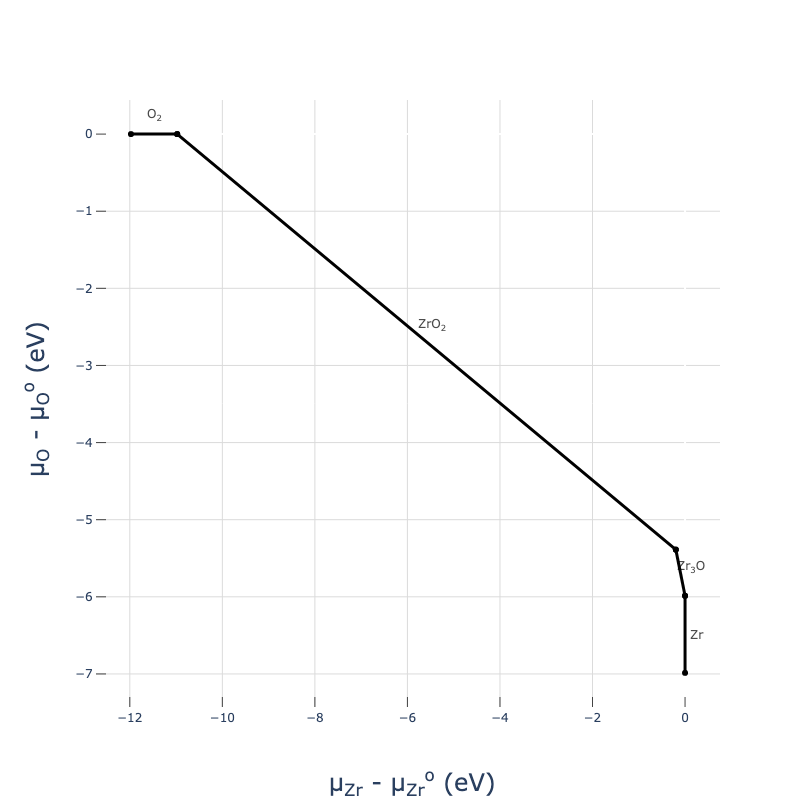

In [12]:
from pymatgen.analysis.chempot_diagram import ChemicalPotentialDiagram
cpd = ChemicalPotentialDiagram(cpa.intrinsic_phase_diagram.entries)
plot = cpd.get_plot()
plot.show("png", dpi=400)

 Because `cpd.get_plot()` returns a `plotly` object, it's almost infinitely customisable using `plot.update_scenes()` - you can change colours, fonts, axes and even data after it's been plotted. See the [docs](https://plotly.com/python/) for more info.

Beware that because we only generated the relevant competing phases on the `Zr-O` phase diagram for our ZrO<sub>2</sub> host material, we have not calculated _all_ phase in the `Zr-O` chemical space (just those that are necessary to determine the chemical potential limits of ZrO<sub>2</sub>), and so these chemical potential diagram plots are only accurate in the vicinity of our host material.

This is an example of what this looks like for a higher-dimensional quaternary system:

In [13]:
from monty.serialization import loadfn

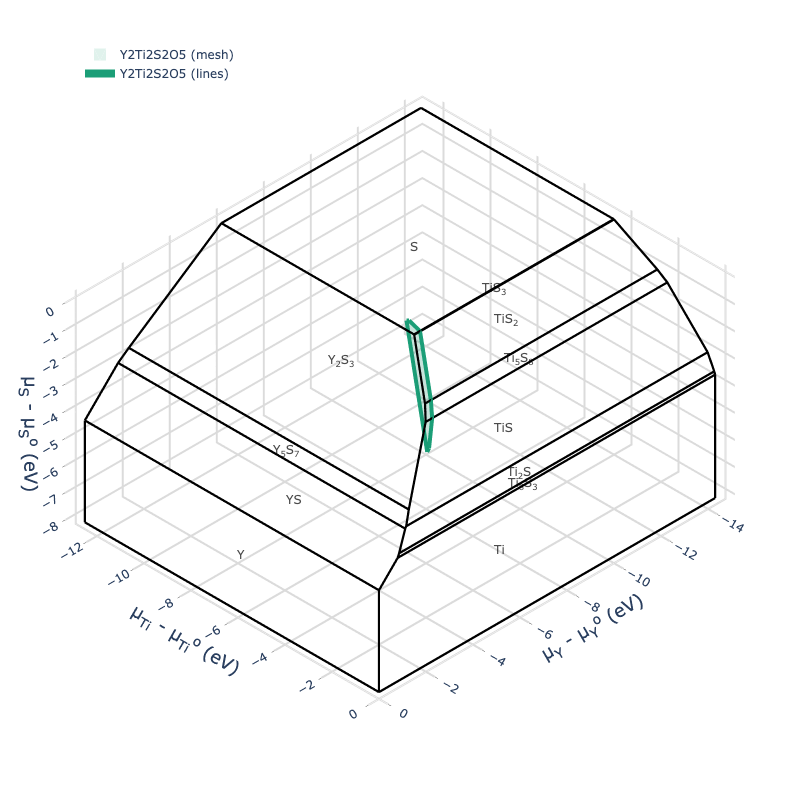

In [14]:
cpd = ChemicalPotentialDiagram(loadfn('competing_phases/ytos_phase_diagram.json').entries)
plot = cpd.get_plot(formulas_to_draw=['Y2Ti2S2O5'])
plot.show("png", dpi=400)

## Parsing Extrinsic Species

Likewise if you've generated and calculated the competing phases for extrinsic species (i.e. to obtain the chemical potential limits for dopants/extrinsic impurities in your host system), you can easily parse them using the same `CompetingPhaseAnalyzer` class.

In [27]:
la_cpa = CompetingPhasesAnalyzer("ZrO2", extrinsic_species="La")
la_cpa.from_vaspruns(path='./competing_phases/La_ZrO2/',
                  folder='relax',
                  csv_path='./competing_phases/zro2_la_competing_phase_energies.csv')
df = la_cpa.calculate_chempots(csv_path='./competing_phases/zro2_la_chempots.csv')

Parsing 11 vaspruns and pruning to include only lowest-energy polymorphs...
Competing phase formation energies have been saved to ./competing_phases/zro2_la_competing_phase_energies.csv.
Calculating chempots for La
Saved chemical potential limits to csv file:  ./competing_phases/zro2_la_chempots.csv
Calculated chemical potential limits: 

          Zr         O        La La_limiting_phase
0 -10.975428  0.000000 -9.462987          La2Zr2O7
1  -0.199544 -5.387942 -1.381074          La2Zr2O7


As before, we can get the chemical potential limits in the format required for `plotting.formation_energy_plot()`, `analysis.formation_energy_table()` etc. using `cpa.chempots`, which can be easily dumped to a reusable `json` file for later use:

In [7]:
from monty.serialization import dumpfn, loadfn

dumpfn(la_cpa.chempots, 'competing_phases/zro2_la_chempots.json')
la_chemlims = loadfn('competing_phases/zro2_la_chempots.json')

## Combining multiple extrinsic chemical potentials

If for example you were interested in simulating defect complexes where you introduce more than one extrinsic defect at a time, or if you wanted to plot all the possible dopant species in one transition level diagram, you will need to combine your chemical potential limits for these extrinsic species.

To combine several extrinsic chemical potential limits, you will need to save the different sets of parsed chemical potentials with `CompetingPhaseAnalyzer` to `chempots.json` files as shown above. You can then combine these chemical potential limits with:

In [28]:
from doped.chemical_potentials import combine_extrinsic
from monty.serialization import loadfn

In [62]:
first = loadfn('competing_phases/zro2_la_chempots.json')
second = loadfn('competing_phases/zro2_y_chempots.json')
extrinsic_species = 'Y' # this should be set to whatever is the extrinsic species in the second dictionary
d = combine_extrinsic(first, second, extrinsic_species)
print(d)

{'elemental_refs': {'O': -7.006602065, 'Zr': -9.84367624, 'La': -5.00458616, 'Y': -5.50458616}, 'facets': {'ZrO2-O2-La2Zr2O7-Y2Zr2O7': {'Zr': -20.81910468, 'O': -7.006602065, 'La': -14.467573640000001, 'Y': -14.967573640000001}, 'Zr3O-ZrO2-La2Zr2O7-Y2Zr2O7': {'Zr': -10.04321996, 'O': -12.394544425, 'La': -6.3856601000000035, 'Y': -6.8856601000000035}}, 'facets_wrt_el_refs': {'ZrO2-O2-La2Zr2O7-Y2Zr2O7': {'Zr': -10.975428439999998, 'O': 0.0, 'La': -9.462987480000002, 'Y': -9.962987480000002}, 'Zr3O-ZrO2-La2Zr2O7-Y2Zr2O7': {'Zr': -0.19954371999999942, 'O': -5.387942359999999, 'La': -1.3810739400000038, 'Y': -1.8810739400000038}}}


As the output of `combine_extrinsic()` is a dictionary, it can either be dumped to a new `json` file with `dumpfn` or you can keep adding new chemical potential limits to it.

NB: the facets must be in the same order in all dictionaries you're combining. Make sure to double check all energies have been combined correctly. 